# Keypoint Estimation Models Analysis

In [66]:
import os
import sys
import math
import git
import cv2
import numpy as np
import torch
import lightning as L
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader, RandomSampler

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(f"{git_root}/keypoint_estimation/")

## Loading data

In [68]:
from datamodule import KeypointEstDataModule

L.seed_everything(42, workers=True)

datamodule = KeypointEstDataModule(
    dataset_dir=os.path.join(
        os.path.expanduser("~"), "Documents/datasets"
    ),
    dataset_mode="ego4d",
    batch_size=1,
    transform_mode="display",
    selection="segsec",
    sample_num=16,
    seg_arg=8,
    neg_ratio=None,
    with_info=True,
    fast_load=True,
)
datamodule.setup()
train_dataset = datamodule.train_data
val_dataset = datamodule.val_data

datamodule.setup(stage="test")
test_dataset = datamodule.test_data

Global seed set to 42


Loading data from preprocessed annotation ...


## Model prediction

In [71]:
def load_model(classifier, weight_path):
    classifier.model.load_state_dict(
        torch.load(
            weight_path,
            map_location=torch.device("cpu"),
        ),
        strict=True,
    )
    return classifier.eval()

### Dataset prediction

In [72]:
from system import KeypointEstModule

classifier = KeypointEstModule(
    model_name="vivit",
    num_out_frames=1,
    mode="binary",
)
classifier = load_model(classifier, "../logs/vivit.pth")

In [69]:
sampler = RandomSampler(train_dataset, num_samples=200)
dataloader = DataLoader(train_dataset, batch_size=1, sampler=sampler)

positive_preds = []
negative_preds = []
for frames, labels, metalabel, info in tqdm(dataloader):
    with torch.no_grad():
        logits = classifier(frames.float())
    preds = logits.sigmoid()

    if labels.max(dim=1, keepdims=True).values == 0:
        negative_preds.append(preds)
    else:
        positive_preds.append(preds)

100%|██████████| 200/200 [04:27<00:00,  1.34s/it]


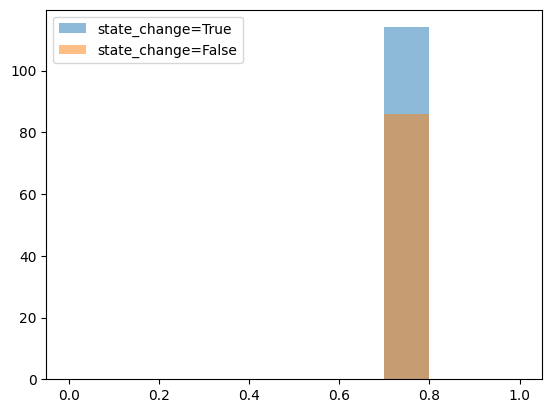

In [70]:
plt.hist(np.array(positive_preds).flatten(), range=(0,1), alpha=0.5, label="state_change=True")
plt.hist(np.array(negative_preds).flatten(), range=(0,1), alpha=0.5, label="state_change=False")

plt.legend()
plt.show()

### Single data prediction

In [ ]:
import matplotlib.colors as clr
import matplotlib.cm as cm

def visualize_predictions(imgs, output):
    fig = plt.figure()
    for i in range(len(imgs)):
        ax = fig.add_subplot(4, 4, 1+i)
        ax.axis("off")
        img = imgs[i]

        # add transparency
        w, h, _ = img.shape
        alpha = np.full((w,h,1), output[0][i] * 0.5 + 0.5)
        img = np.dstack([img, alpha])

        # add red surrounding box
        if labels[0][i] == 1:
            thickness = 5
            img[:thickness, :, :] = (1,0,0,1)
            img[-thickness:, :, :] = (1,0,0,1)
            img[:, :thickness, :] = (1,0,0,1)
            img[:, -thickness:, :] = (1,0,0,1)

        plt.imshow(img)

    plt.show()

def visualize_attention_maps(attention):
    fig = plt.figure()
    for layer in range(len(attention)):
        ax = fig.add_subplot(3, 4, 1+layer)
        ax.axis("off")

        att = attention[layer].mean(dim=1).squeeze(0).detach().numpy().copy()
        plt.imshow(att)
        plt.colorbar()

    plt.show()

def visualize_class_attention(
    imgs, attention, layer=-1, cls_token=0, cls_token_num=1, average_head=True,
    head=0, show_raw_map=False,
):
    # get class attention of layer (usually last layer)
    cls_att = attention[layer][:,:,cls_token,cls_token_num:]
    if average_head:
        cls_att = cls_att.mean(dim=1).squeeze(0)
    else:
        cls_att = cls_att.squeeze(0)[head]
    cls_att = cls_att.view(8,14,14).detach().numpy().copy()

    # visualize class attention maps
    if show_raw_map:
        fig = plt.figure()
        for d in range(int(len(imgs)/2)):
            ax = fig.add_subplot(2, 4, 1+d)
            ax.axis("off")
            plt.imshow(cls_att[d])

        plt.show()

    # visualize class attention maps with input frames
    fig = plt.figure()
    for i in range(len(imgs)):
        ax = fig.add_subplot(4, 4, 1+i)
        ax.axis("off")
        img = imgs[i]

        cls_att_map = cv2.resize(cls_att[math.floor(i/2)], (224,224))
        # normalize to range 0~1
        map_min, map_max = np.min(cls_att_map), np.max(cls_att_map)
        norm_map = (cls_att_map - map_min)/(map_max - map_min)

        plt.imshow(img)
        plt.imshow(norm_map, alpha=0.4, cmap="jet")

    # create new axis for colorbar, and show
    plt.subplots_adjust(right=0.8)
    plt.colorbar(
        cm.ScalarMappable(norm=clr.Normalize(vmin=0, vmax=1), cmap="jet"),
        cax=fig.add_axes([0.85,0.15,0.05,0.7]),
    )

    plt.show()

In [73]:
from system import KeypointEstModule

# prepare models (can be multiple)
classifier_list = [
    KeypointEstModule(
        model_name="vivit",
        with_attention=True,
    ),
    KeypointEstModule(
        model_name="vivit",
        patch_size=[1, 224, 224],
        with_attention=True,
    ),
    KeypointEstModule(
        model_name="vivit",
        patch_size=[1, 224, 224],
        with_attention=True,
    ),
    KeypointEstModule(
        model_name="mctvivit",
        with_attention=True,
    )
]

weight_path_list = [
    f"{git_root}/keypoint_estimation/logs/vivit_cls/vivit.pth",
    f"{git_root}/keypoint_estimation/logs/vivit_temp_phead/vivit.pth",
    f"{git_root}/keypoint_estimation/logs/vivit.pth",
    f"{git_root}/keypoint_estimation/logs/mctvivit/mctvivit.pth",
]

assert len(classifier_list) == len(weight_path_list)

In [75]:
# prepare dataloader
datamodule.setup(stage="test")
dataloader = iter(datamodule.test_dataloader())
iter_counter = 0

iter counter: 1
vid: 6834426d-9454-4fc9-a538-20d498d18e87 from 1 to 240 
frames shape: torch.Size([1, 16, 3, 224, 224])
label shape: torch.Size([1, 16])
converted frames shape: (16, 224, 224, 3)


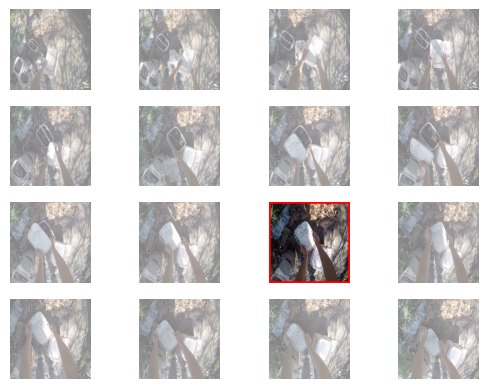

In [76]:
frames, labels, metalabel, info = next(dataloader)
iter_counter += 1

imgs = frames.permute(0,1,3,4,2).detach().numpy().copy()[0]

print(
    f"iter counter: {iter_counter}",
    (
        f"vid: {info['video_uid'][0]} " + \
        f"from {int(info['segment_start_frame'])} " + \
        f"to {int(info['segment_end_frame'])} "
    ),
    f"frames shape: {frames.shape}",
    f"label shape: {labels.shape}",
    f"converted frames shape: {imgs.shape}",
    sep="\n",
)

# visualize data
fig = plt.figure()
for i in range(len(imgs)):
    ax = fig.add_subplot(4, 4, 1+i)
    ax.axis("off")
    # ax.axes.get_xaxis().set_visible(False)
    # ax.axes.get_yaxis().set_visible(False)
    img = imgs[i]

    # add transparency
    w, h, _ = img.shape
    alpha = np.full((w,h,1), labels[0][i] * 0.5 + 0.5)
    img = np.dstack([img, alpha])

    # add red surrounding box
    # cv2.rectangle does not support image with (w,h,c,a)
    if labels[0][i] == 1:
        thickness = 5
        img[:thickness, :, :] = (1,0,0,1)
        img[-thickness:, :, :] = (1,0,0,1)
        img[:, :thickness, :] = (1,0,0,1)
        img[:, -thickness:, :] = (1,0,0,1)

    plt.imshow(img)

plt.show()

plt.clf()
plt.close()

preds: 
	tensor([[0.3370, 0.4267, 0.3480, 0.4800, 0.4574, 0.4130, 0.3274, 0.4171, 0.4025,
         0.3516, 0.4221, 0.4366, 0.3729, 0.4424, 0.4393, 0.3378]])
preds with threshold=0.5: 
	tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
GT labels: 
	tensor([[1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.]],
       dtype=torch.float64)
attention: 
	torch.Size([1, 12, 1569, 1569])


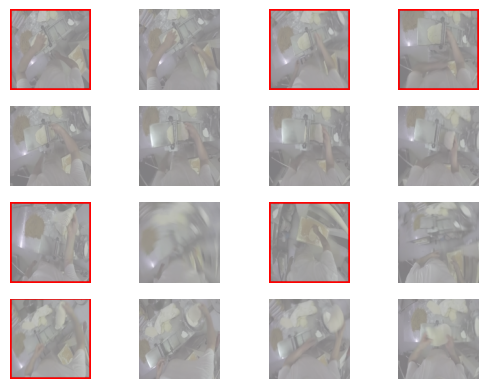

preds: 
	tensor([[0.6159, 0.4006, 0.4540, 0.5280, 0.4144, 0.3069, 0.2943, 0.4446, 0.3554,
         0.5982, 0.3611, 0.5026, 0.4601, 0.6341, 0.6221, 0.6049]])
preds with threshold=0.5: 
	tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.]])
GT labels: 
	tensor([[1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.]],
       dtype=torch.float64)
attention: 
	torch.Size([1, 12, 17, 17])


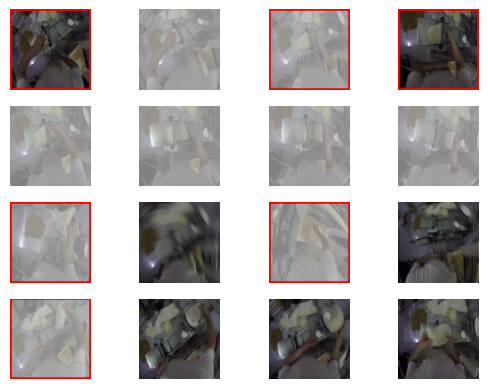

preds: 
	tensor([[0.3955, 0.6735, 0.2969, 0.4947, 0.4416, 0.2692, 0.4800, 0.5210, 0.6529,
         0.4471, 0.6270, 0.5318, 0.4831, 0.8022, 0.5964, 0.7575]])
preds with threshold=0.5: 
	tensor([[0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.]])
GT labels: 
	tensor([[1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.]],
       dtype=torch.float64)
attention: 
	torch.Size([1, 12, 17, 17])


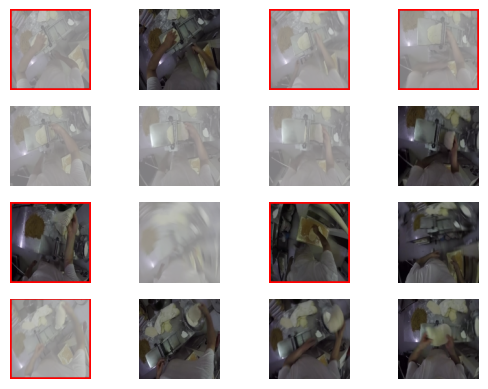

preds: 
	tensor([[0.3948, 0.4258, 0.4182, 0.3978, 0.3870, 0.4280, 0.4176, 0.4060, 0.4030,
         0.4805, 0.4213, 0.4172, 0.3876, 0.4443, 0.3566, 0.3810]])
preds with threshold=0.5: 
	tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
GT labels: 
	tensor([[1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.]],
       dtype=torch.float64)
attention: 
	torch.Size([1, 12, 1584, 1584])


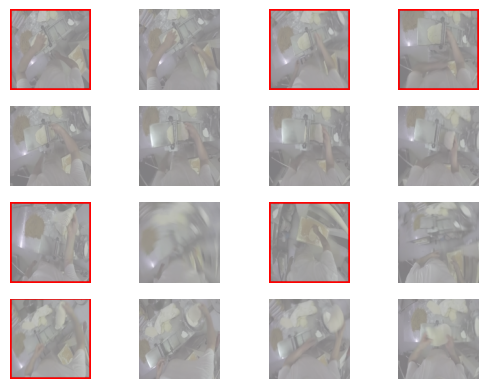

In [279]:
for classifier, weight_path in zip(classifier_list, weight_path_list):
    classifier.model.load_state_dict(
        torch.load(
            weight_path,
            map_location=torch.device("cpu"),
        ),
        strict=True,
    )
    classifier.eval()

    with torch.no_grad():
        logits, attention = classifier(frames.float())
    preds = logits.sigmoid()
    output = (preds > (threshold:=0.5)).float()

    print(
        f"preds: \n\t{preds}",
        f"preds with threshold={threshold}: \n\t{output}",
        f"GT labels: \n\t{labels}",
        f"attention: \n\t{attention[0].shape}",
        sep="\n",
    )

    # visualize predictions
    visualize_predictions(imgs, output)

    # visualize attention maps
    # visualize_attention_maps(attention)

    # visualize class attention maps of last layer
    # visualize_class_attention(imgs, attention, show_raw_map=True, cls_token=0, cls_token_num=1)

    plt.clf()
    plt.close()

### Comparison between pretrained data

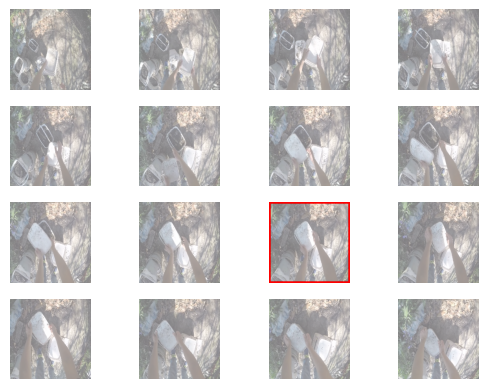

RuntimeError: shape '[8, 14, 14]' is invalid for input of size 1583

In [8]:
weight_paths = [
    f"{git_root}/keypoint_estimation/logs/asyml/vivit.pth",
    f"{git_root}/keypoint_estimation/logs/asyml_mae/vivit.pth",
    f"{git_root}/keypoint_estimation/logs/asyml_transunet/vivit.pth",
]

weight_dict = {
    "videomae_k400": f"{git_root}/keypoint_estimation/logs/checkpoint.pth",
    "transunet": f"{git_root}/keypoint_estimation/logs/transunet.pth",
}

from models import adjust_param
for k, v in weight_dict.items():
    param = torch.load(v, map_location=torch.device("cpu"))
    classifier.model.load_state_dict(
        adjust_param(param, k),
        strict=False,
    )
    classifier.eval()

    with torch.no_grad():
        logits, attention = classifier(frames.float())
    preds = logits.sigmoid()
    output = (preds > (threshold:=0.5)).float()

    visualize_predictions(imgs, output)
    visualize_class_attention(imgs, attention)

# for w in weight_paths:
#     classifier.model.load_state_dict(
#         torch.load(w, map_location=torch.device("cpu")),
#         strict=True,
#     )
#     classifier.eval()

#     with torch.no_grad():
#         logits, attention = classifier(frames.float())
#     preds = logits.sigmoid()
#     output = (preds > (threshold:=0.5)).float()

#     visualize_predictions(imgs, output)
#     visualize_attention_maps(attention)
#     visualize_class_attention(imgs, attention)

plt.clf()
plt.close()